# Library Imports

In [1]:
import tensorflow as tf
import keras
from keras import layers
import os
import numpy as np
from sklearn.model_selection import train_test_split
import scipy
import matplotlib.pyplot as plt
import time
import cv2

2024-11-03 19:02:00.898388: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 19:02:00.898498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 19:02:01.034974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset loading
dataset Courtesy: Mehran Soltani,et.al.

In [2]:
srcdata = scipy.io.loadmat('/kaggle/input/ofdmdataset-mehransoltani/ofdm_data/My_noisy_H_22.mat')
rcvdata = scipy.io.loadmat('/kaggle/input/ofdmdataset-mehransoltani/ofdm_data/Perfect_H_40000.mat')
srcdata_ofdm= abs(srcdata['My_noisy_H']).reshape(-1,72,14,1)
rcvdata_ofdm= abs(rcvdata['My_perfect_H']).reshape(-1,72,14,1)
# trainData,testData, trainLabels, testLabels = train_test_split(srcdata_ofdm,rcvdata_ofdm,test_size=0.2,shuffle=False)

In [3]:
np.shape(srcdata['My_noisy_H'])

(40000, 72, 14)

# Data Exploration and LS Benchmark

In [4]:
# a=rcvdata['My_perfect_H'] #tx
# b=srcdata['My_noisy_H']  #rx
# # pilotstx=a[:,4:65:4,2:13:2]
# # pilotsrx=b[:,4:65:4,2:13:2]
# pilotstx=a
# pilotsrx=b
# plt.subplot(1,2,1)
# plt.imshow(abs(pilotstx[0]))
# plt.title('TX')
# plt.subplot(1,2,2)
# plt.imshow(abs(pilotsrx[0]))
# plt.title('RX')
# print(np.shape(pilotstx))

In [5]:
trainData,testData, trainLabels, testLabels = train_test_split(srcdata_ofdm,rcvdata_ofdm,test_size=0.2,shuffle=False)

In [6]:
# trainData,testData, trainLabels, testLabels = train_test_split(pilotsrx,pilotstx,test_size=0.2,shuffle=False)

In [7]:
# ping=time.time()
# ls=trainData/trainLabels
# pong=time.time()
# print("Len of ls is",np.shape(ls))
# res=np.fft.fft(np.fft.ifft(testData)*np.fft.ifft(np.mean(ls,axis=0)))
# print('est')
# print(res[0,0:5,0:5])
# print("tx")
# print(testLabels[0,0:5,0:5])
# print("rx")
# print(testData[0,0:5,0:5])
# print("Len of tesdat is",np.shape(testData))
# print("Len of res is",np.shape(res))

# print(f"Time taken to channel estimate using LS: {(pong-ping)*100}ms")

In [8]:
# num=0
# plt.subplot(1,3,1)
# plt.imshow(abs(testLabels[num]))
# plt.title('TX')
# plt.subplot(1,3,2)
# plt.imshow(abs(testData[num]))
# plt.title('RX')
# plt.subplot(1,3,3)
# plt.imshow(abs(res[num]))
# plt.title('EST')

In [9]:
# print(np.mean(testData-testLabels))
# print(np.mean(res-testLabels))

In [10]:
# restrain=np.fft.fft(np.fft.ifft(trainData)*np.fft.ifft(np.mean(ls,axis=0)))

In [11]:
# trainset=(np.transpose((restrain.real,restrain.imag),[1,2,3,0]), np.transpose((trainLabels.real,trainLabels.imag),[1,2,3,0]))
# trainset=np.transpose(trainset,[1,0,2,3,4])
# testset=(np.transpose((res.real,res.imag),[1,2,3,0]), np.transpose((testLabels.real,testLabels.imag),[1,2,3,0]))
# testset=np.transpose(testset,[1,0,2,3,4])

In [12]:
trainset=(trainData, trainLabels)
trainset=np.transpose(trainset,[1,0,2,3,4])
testset=(testData, testLabels)
testset=np.transpose(testset,[1,0,2,3,4])

In [13]:
np.shape(testset)

(8000, 2, 72, 14, 1)

# Downsample Block (part of Generator)

In [14]:
OUTPUT_CHANNELS = 1
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [15]:
inp=trainset[1][1]
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 72, 14, 3)


# Upsample Block (part of Generator)

In [16]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=1,
                    padding='same',
                    kernel_initializer=initializer,
                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())
    return result

In [17]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 72, 14, 3)


# Generator Definition

In [18]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[72, 14, 1])
    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=1,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='linear')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x,name='Generator')

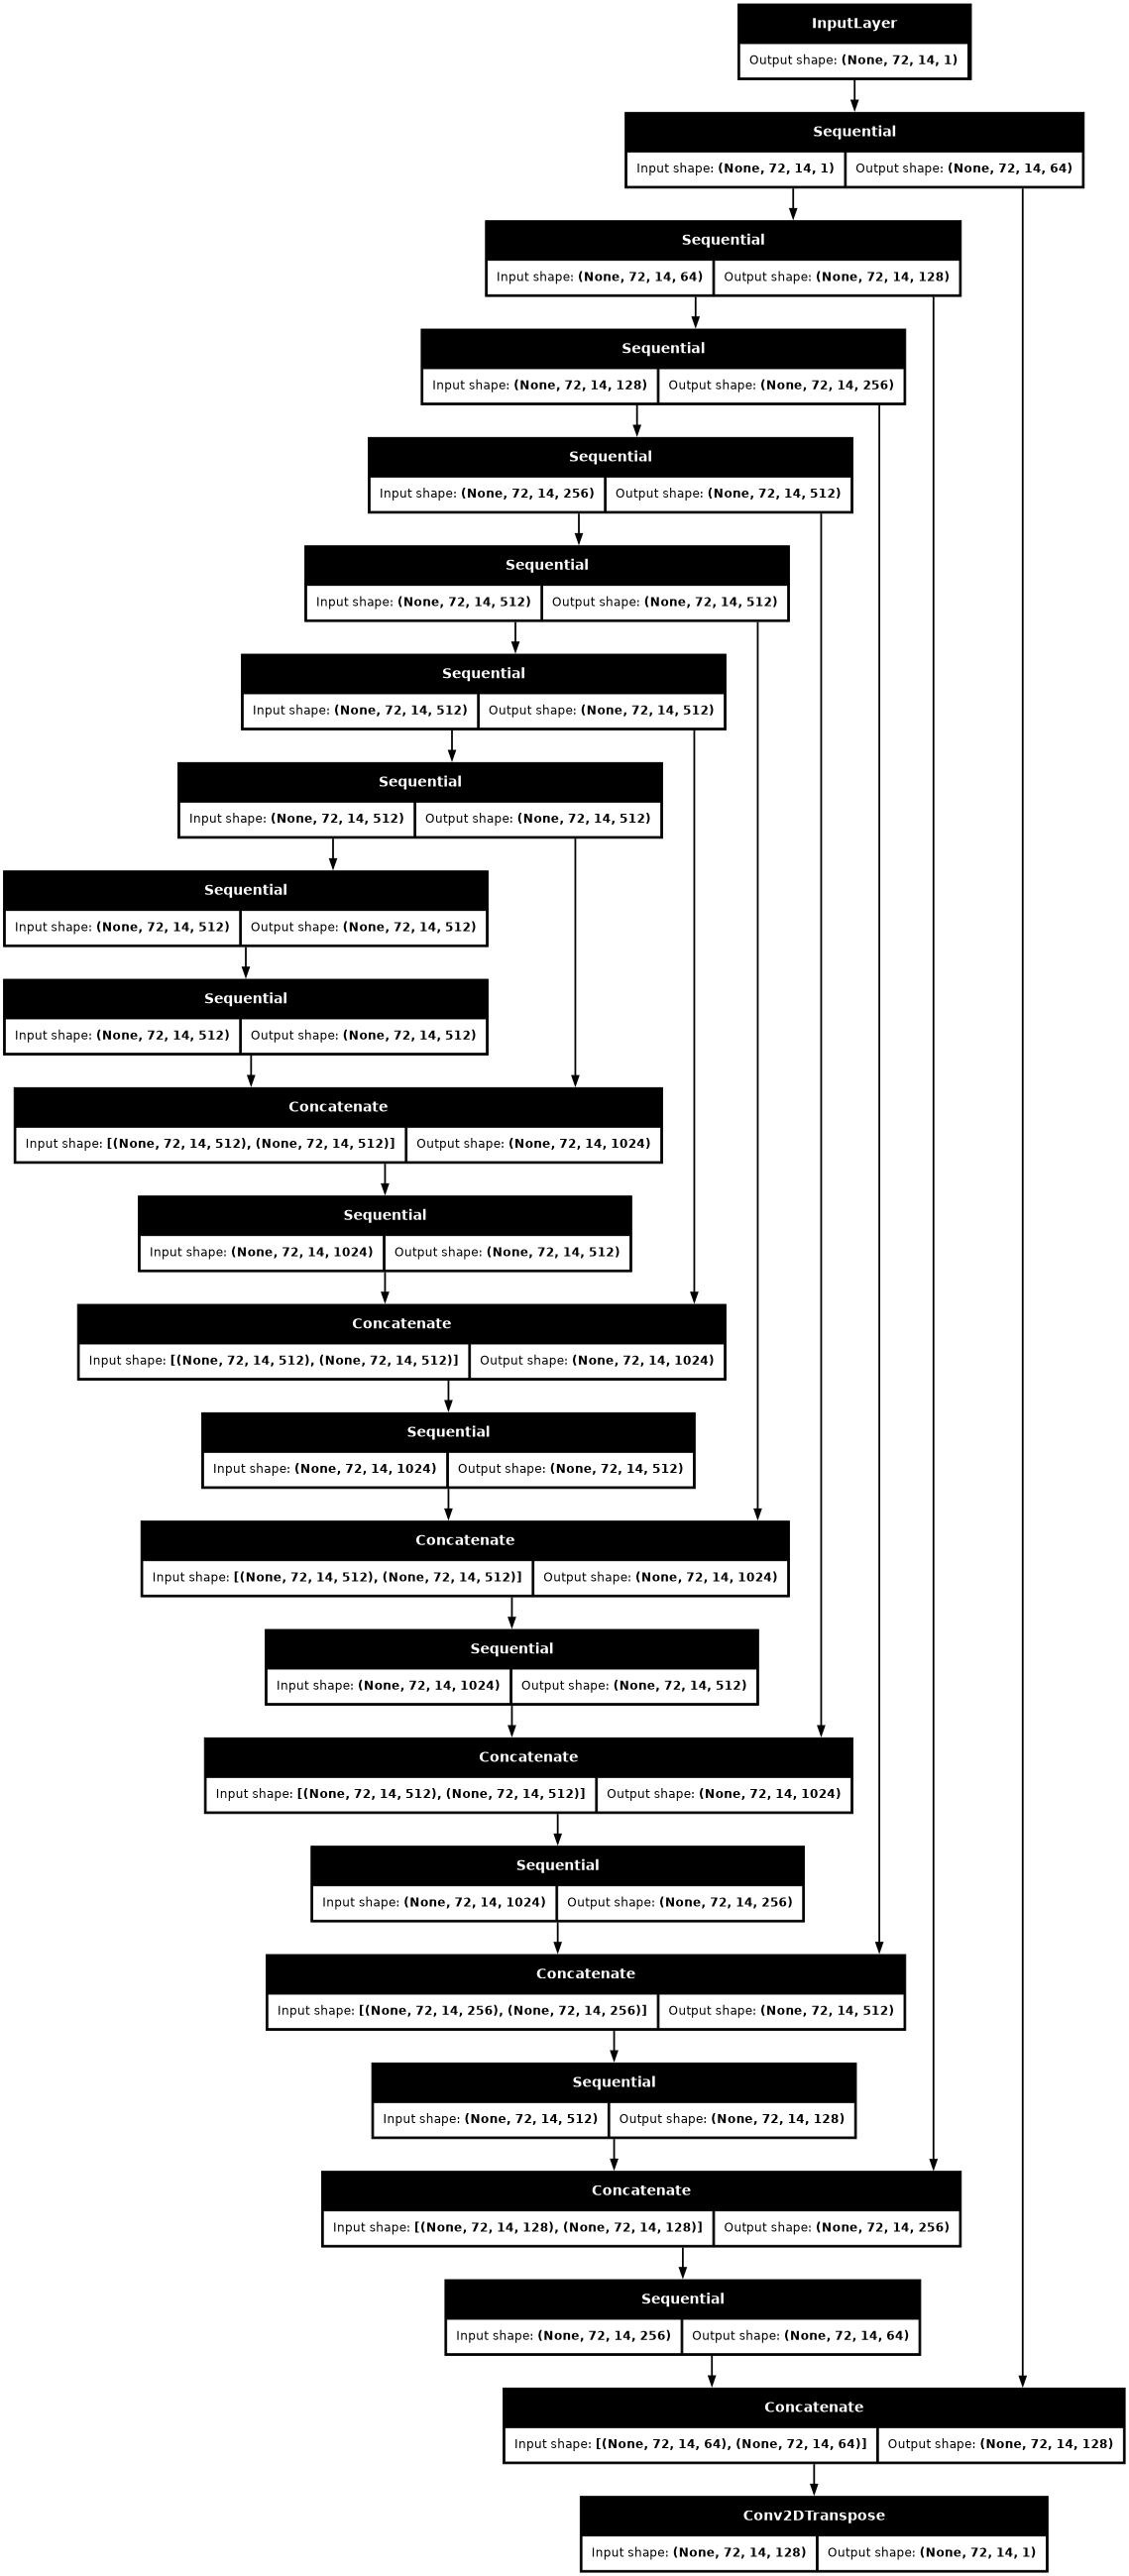

In [19]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

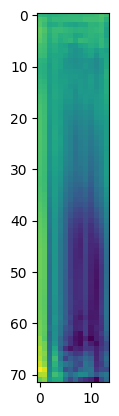

In [20]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.subplot(1,2,1)
plt.imshow(gen_output[0,:,:,0])

# plt.subplot(1,2,2)
# plt.imshow(gen_output[0,:,:,1])

# Generator Loss

In [21]:
LAMBDA = 1000
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.cast(loss_object(tf.ones_like(tf.cast(disc_generated_output,dtype=tf.float64)), tf.cast(disc_generated_output,dtype=tf.float64)),dtype=tf.float64)
    # Mean absolute error
    l1_loss = tf.cast(tf.reduce_mean(tf.square(tf.cast(target,dtype=tf.float64) - tf.cast(gen_output,dtype=tf.float64))),dtype=tf.float64)
    total_gen_loss = (LAMBDA*gan_loss) + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

# Discriminator Definition

In [22]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inpt = tf.keras.layers.Input(shape=[72, 14, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[72, 14, 1], name='target_image')
    x = tf.keras.layers.concatenate([inpt, tar])  # (batch_size, 256, 256, channels*2)
    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(1, 4, strides=1,padding='same',
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,padding='same',
                                kernel_initializer=initializer,activation='relu')(zero_pad2)  # (batch_size, 30, 30, 1)

    fa=tf.keras.layers.Flatten()(last)
    de=tf.keras.layers.Dense(1,activation='sigmoid')(fa)
    return tf.keras.Model(inputs=[inpt, tar], outputs=de,name='Discriminator')

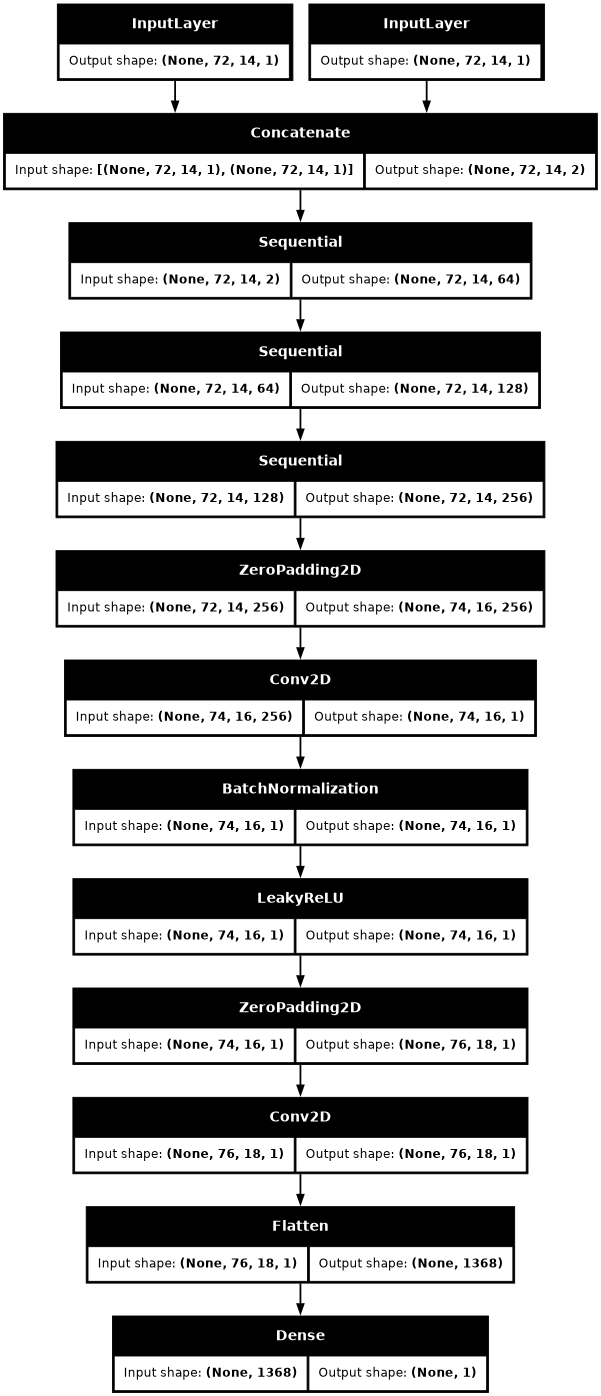

In [23]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [24]:
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 72, 14, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 72, 14,    │      1,024 │ input_layer_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 72, 14,    │    131,584 │ sequential_2[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 72, 14,    │    525,312 │ sequential_3[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 72, 14,    │  2,099,200 │ sequential_4[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 72, 14,    │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 72, 14,    │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 72, 14,    │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 72, 14,    │  4,196,352 │ sequential_8[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 72, 14,    │  4,196,352 │ sequential_9[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 72, 14,    │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 72, 14,    │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 72, 14,    │          0 │ sequential_11[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 72, 14,    │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 72, 14,    │          0 │ sequential_12[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 72, 14,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 72, 14,    │          0 │ sequential_13[0]

 Total params: 54,419,713 (207.59 MB)

 Trainable params: 54,408,833 (207.55 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [25]:
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 72, 14, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 72, 14, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 72, 14, 2) │          0 │ input_image[0][0… │
│ (Concatenate)       │                   │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 72, 14,    │      2,048 │ concatenate_7[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_18       │ (None, 72, 14,    │    131,584 │ sequential_17[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_19       │ (None, 72, 14,    │    525,312 │ sequential_18[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 74, 16,    │          0 │ sequential_19[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 74, 16, 1) │      4,096 │ zero_padding2d[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 16, 1) │          4 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 74, 16, 1) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 76, 18, 1) │          0 │ leaky_re_lu_12[0… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 76, 18, 1) │         17 │ zero_padding2d_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1368)      │          0 │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      1,369 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 664,430 (2.53 MB)

 Trainable params: 663,660 (2.53 MB)

 Non-trainable params: 770 (3.01 KB)

# Discriminator Loss

In [26]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.cast(loss_object(tf.ones_like(tf.cast(disc_real_output,dtype=tf.float64)), tf.cast(disc_real_output,dtype=tf.float64)),dtype=tf.float64)
    generated_loss = tf.cast(loss_object(tf.zeros_like(tf.cast(disc_generated_output,dtype=tf.float64)), tf.cast(disc_generated_output,dtype=tf.float64)),dtype=tf.float64)
    total_disc_loss = 1000*real_loss + 1000*generated_loss
    return total_disc_loss

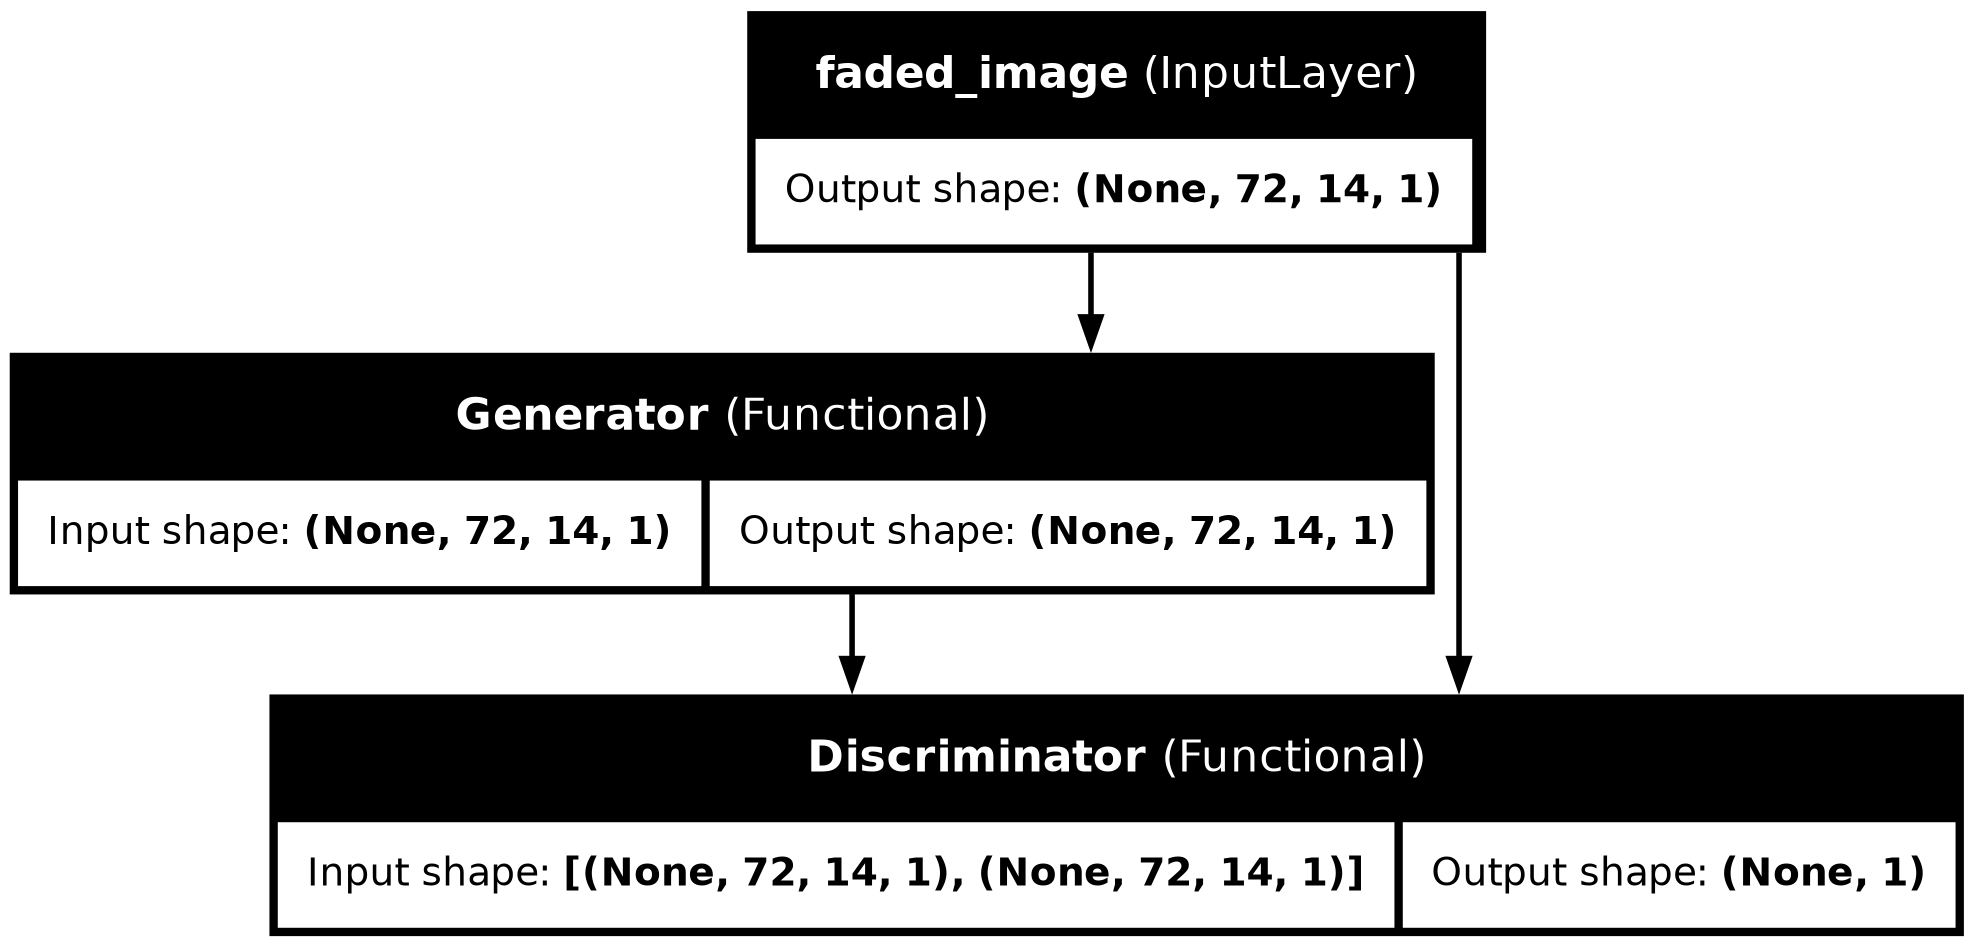

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, Dense, Add, Flatten, Reshape, LeakyReLU,ReLU
from tensorflow.keras.models import Model

faded_image = Input(shape=[72, 14, 1], name="faded_image")
clean_image = generator([faded_image])
validity = discriminator([clean_image, faded_image])
gan = Model(faded_image, validity, name="cGAN")
gan.compile(optimizer='adam', loss='binary_crossentropy')
keras.utils.plot_model(gan,show_layer_names=True,show_shapes=True)

# Optimiziers

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.4)
discriminator_optimizer = tf.keras.optimizers.Adagrad(2e-3)

# Gradient Tape

In [29]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                   discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))
#Note to self: Might wanna check these out LN, Also check TF grad tape docs and work these out, summary misbhevaes since eager execution rolled out, 
#   with summary_writer.as_default():
#     tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
#     tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
#     tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
#     tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
def generate_images(model, test_input, tar):
    prediction = model(test_input.reshape(1,72,14,1), training=True)
    plt.figure(figsize=(15, 15))

    # display_list = [test_input[:,:,0],test_input[:,:,1], tar[:,:,0], prediction[0][:,:,0],tar[:,:,1],prediction[0][:,:,1]]
    # title = ['Input Image Real','Input Image CMPLX', 'Ground Truth Real', 'Predicted Image Real', 'Ground Truth CMPLX','Predicted Image CMPLX']

    # for i in range(6):
    #     plt.subplot(3, 2, i+1)
    #     plt.title(title[i])
    #     # Getting the pixel values in the [0, 1] range to plot.
    #     plt.imshow(display_list[i] * 0.5 + 0.5)
    #     plt.axis('off')
    # plt.show()

    display_list = [test_input[:,:,0],tar[:,:,0], prediction[0][:,:,0]]
    title = ['Input Image','Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

# Fit routine

In [32]:
import random
import gc
import numpy as np
def fit(train_ds, test_ds, steps, batch):
    #(example_input, example_target) = next(iter(test_ds))
    #(example_input, example_target) = random.choice(test_ds)
    start = time.time()

    for step in range(len(train_ds)):
        
        if (step) % 50 == 0:
            print('ok')
            if step != 0:
                print(f'Time taken for 50 steps: {time.time()-start:.2f} sec\n')

            start = time.time()
            (example_input, example_target) = random.choice(test_ds)
            generate_images(generator, example_input, example_target)
            print(f"Step: {step}")
            del example_input
            del example_target
            gc.collect()

        (inpo, outp) = np.transpose(random.choices(train_ds,k=batch),[1,0,2,3,4])
        train_step(inpo.reshape(batch,72,14,1).astype(np.float64), outp.reshape(batch,72,14,1).astype(np.float64), step)
        del inpo
        del outp
        gc.collect()

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) for the model every 50 steps
        if (step + 1) % 25 == 0:
            #checkpoint.save(file_prefix=checkpoint_prefix)
            continue

        if step==steps:
            break


ok


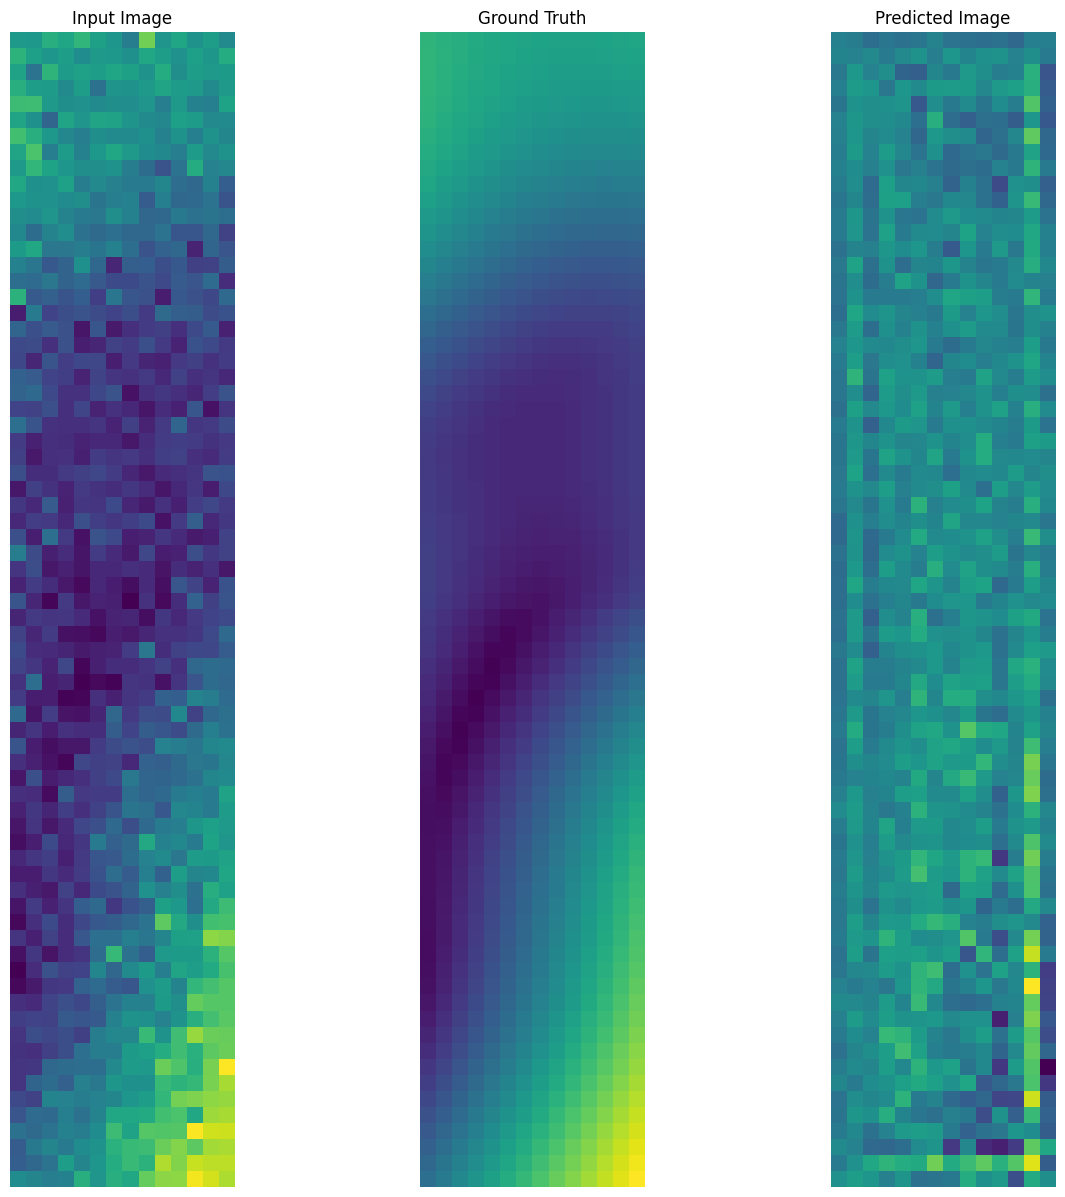

Step: 0


2024-11-03 19:02:46.066114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-03 19:03:47.677831: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


..

2024-11-03 19:04:50.638648: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:05:51.344440: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:06:54.590629: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.ok
Time taken for 50 steps: 297.42 sec



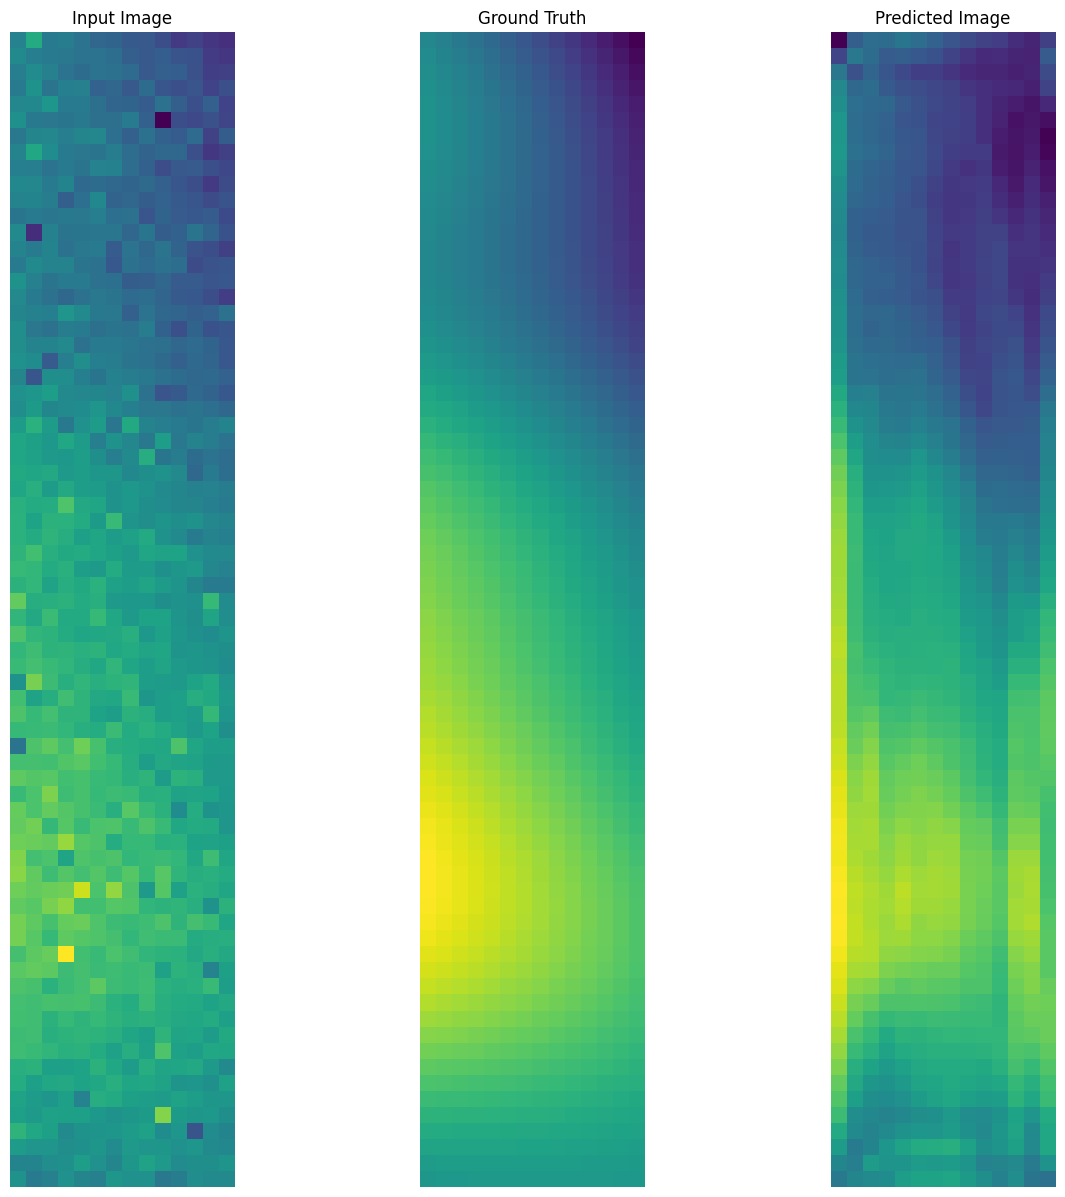

Step: 50


2024-11-03 19:07:55.920068: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:08:57.822983: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:10:01.493685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:11:06.841710: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:12:07.458944: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.ok
Time taken for 50 steps: 326.62 sec



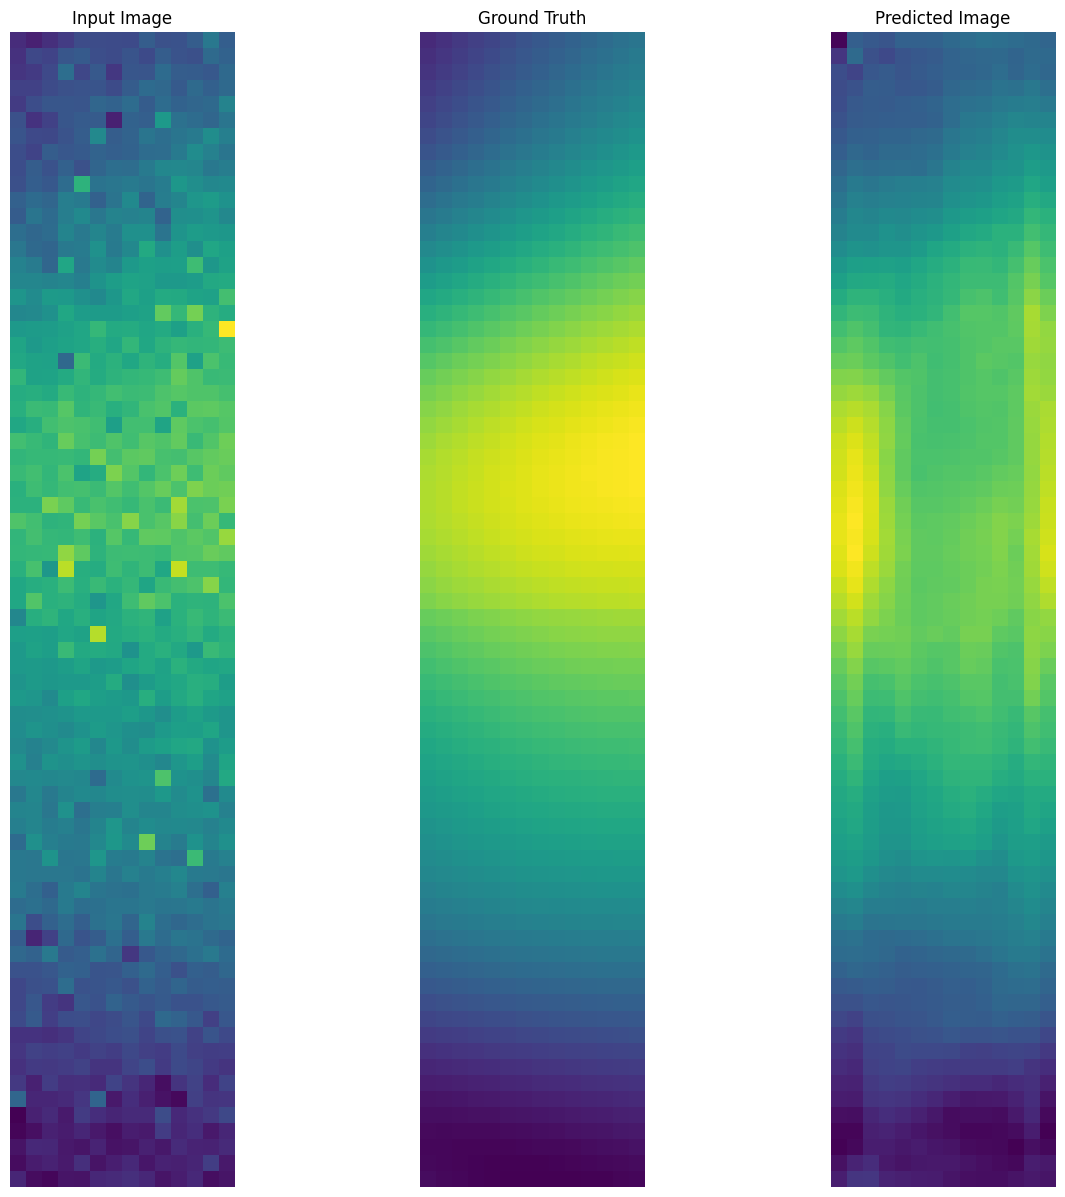

Step: 100


2024-11-03 19:13:12.540835: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:14:16.798206: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-03 19:15:22.684082: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:16:29.970719: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:17:31.571695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:18:34.451553: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.ok
Time taken for 50 steps: 379.79 sec



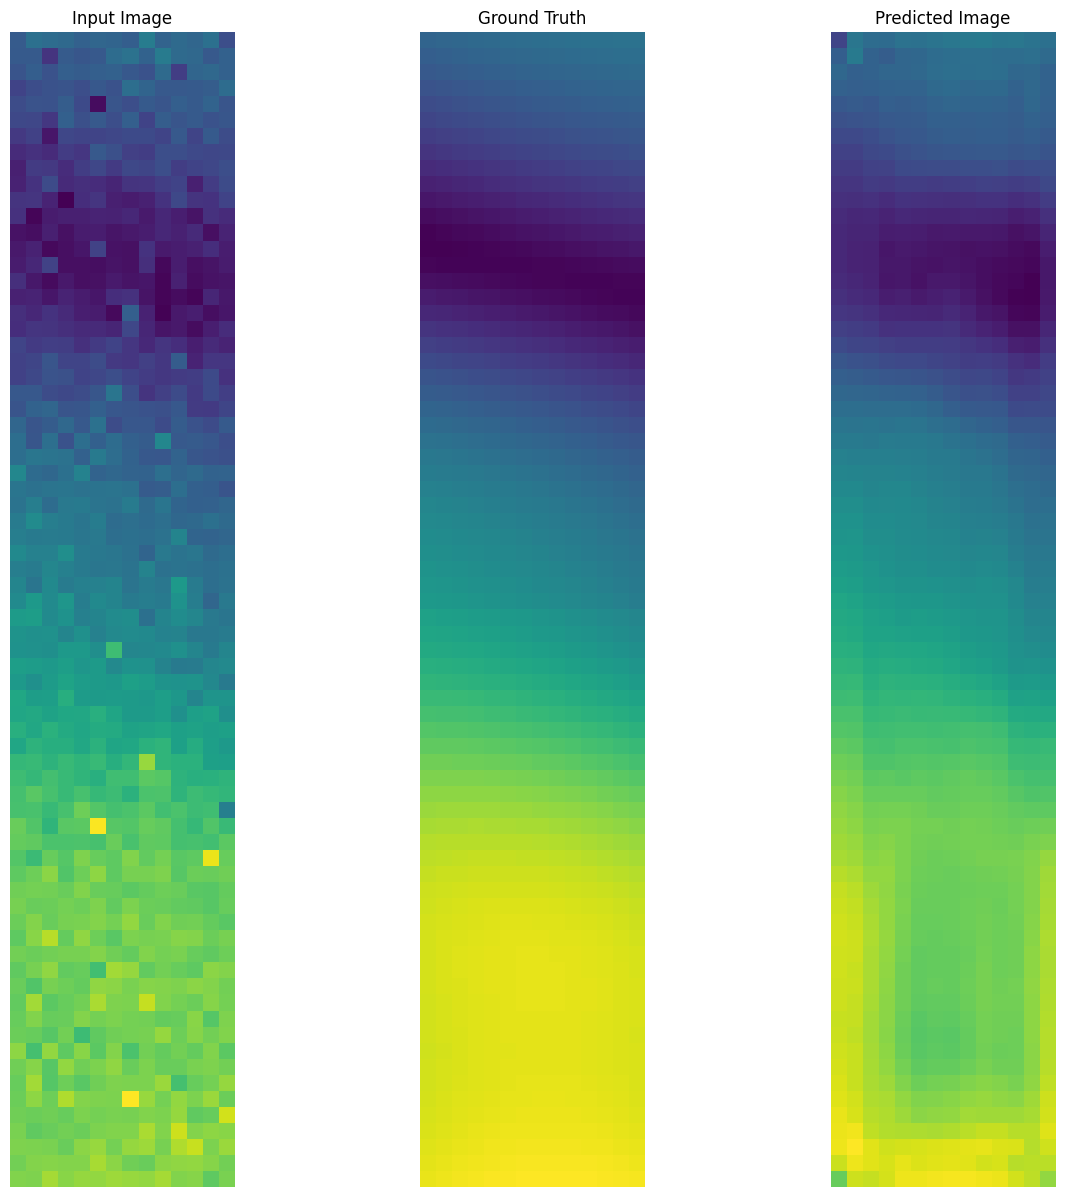

Step: 150


2024-11-03 19:19:42.446202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:20:47.735400: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-03 19:21:54.346364: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:23:01.882300: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:24:02.154402: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:25:04.493540: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-03 19:26:07.876077: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.ok
Time taken for 50 steps: 432.76 sec



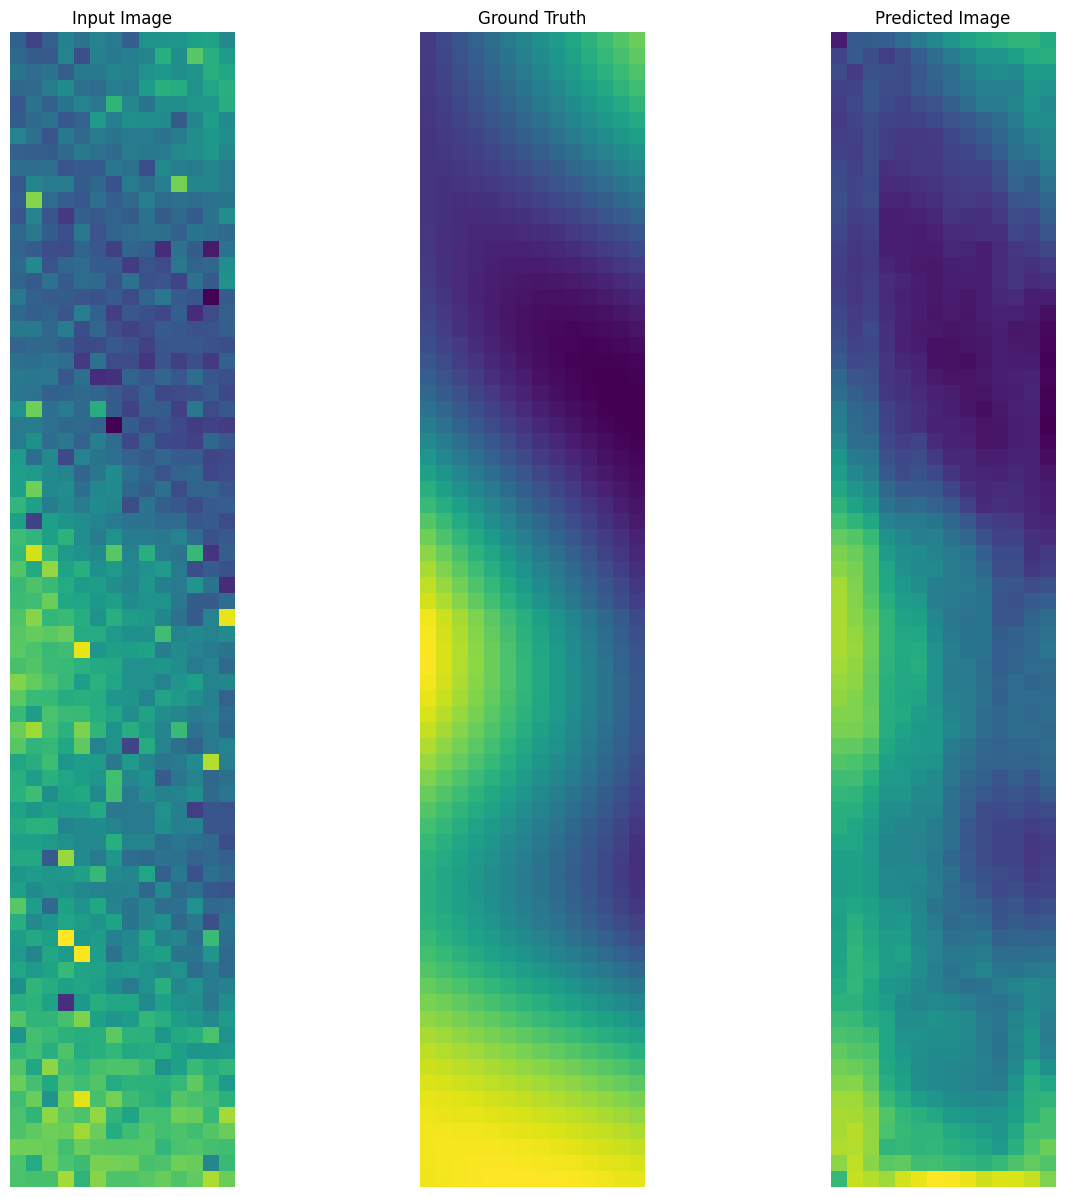

Step: 200


2024-11-03 19:27:16.343209: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:28:20.527045: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-03 19:29:25.545173: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:30:31.740723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:31:39.404327: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-03 19:32:47.864213: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:33:57.344672: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.ok
Time taken for 50 steps: 482.15 sec



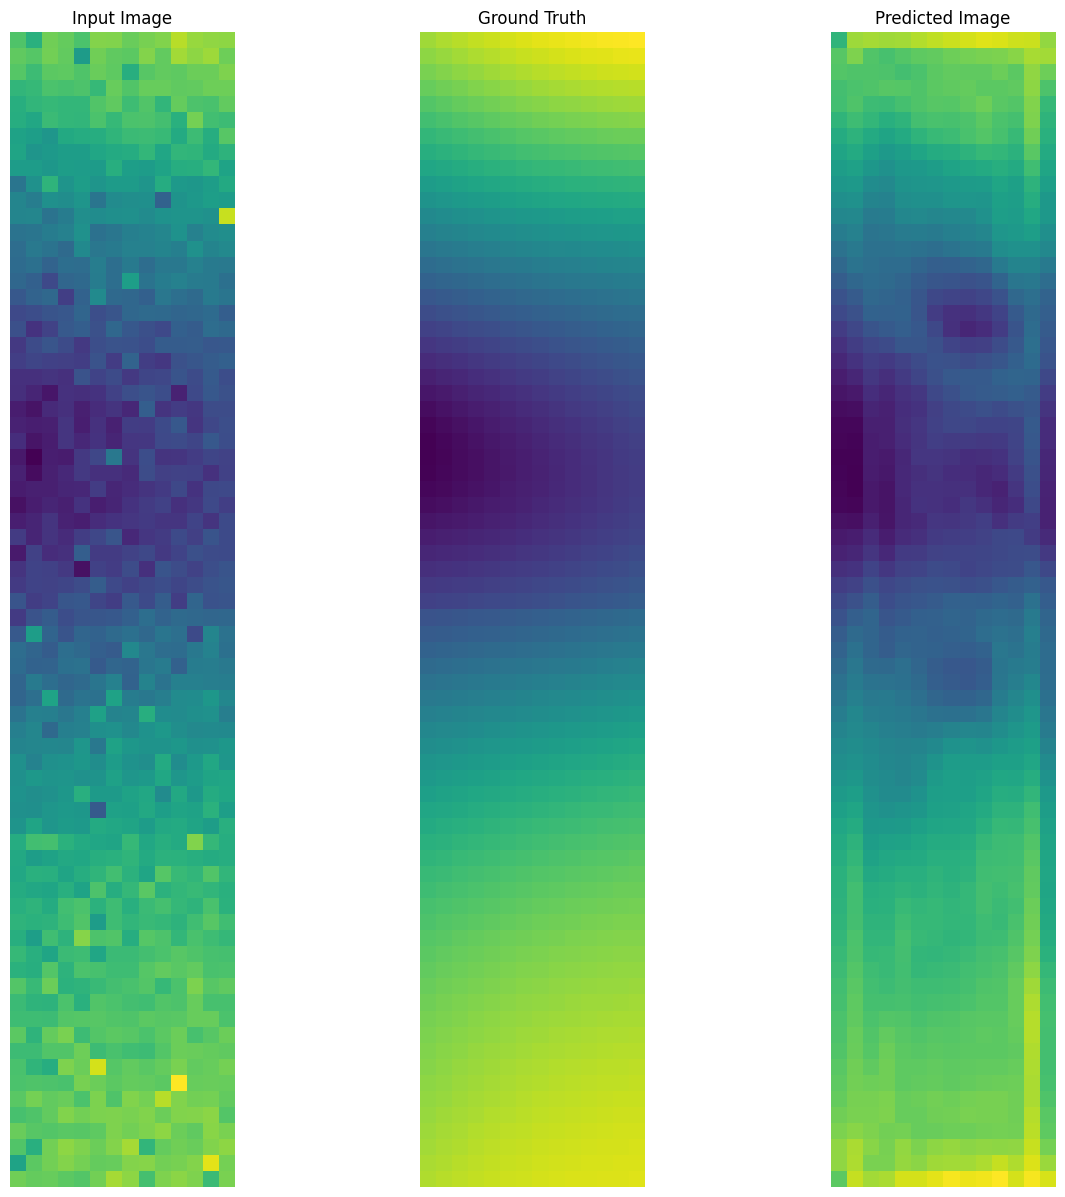

Step: 250


2024-11-03 19:35:03.833762: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-03 19:36:04.750712: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:37:06.627143: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:38:09.413398: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-03 19:39:12.520123: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:40:16.774084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-03 19:41:21.229622: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:42:26.620167: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.ok
Time taken for 50 steps: 535.35 sec



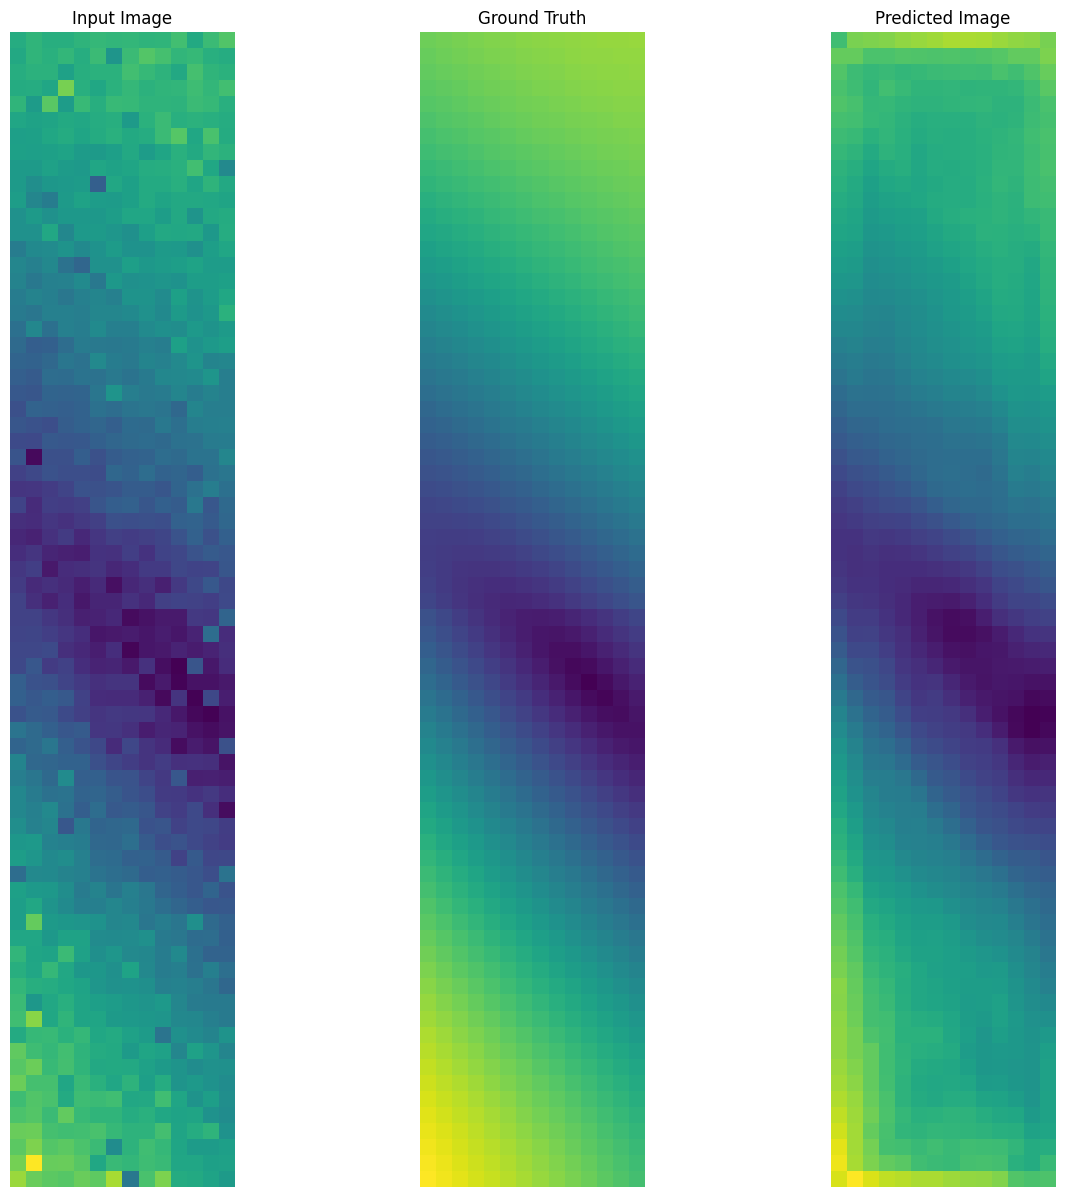

Step: 300


2024-11-03 19:43:39.575605: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-03 19:44:47.548522: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:45:55.770393: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-03 19:47:04.229329: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:48:13.924246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:49:24.990219: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-03 19:50:36.062048: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.

2024-11-03 19:51:47.792601: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-03 19:52:48.204562: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGenerator_1/sequential_10_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


.ok
Time taken for 50 steps: 591.99 sec



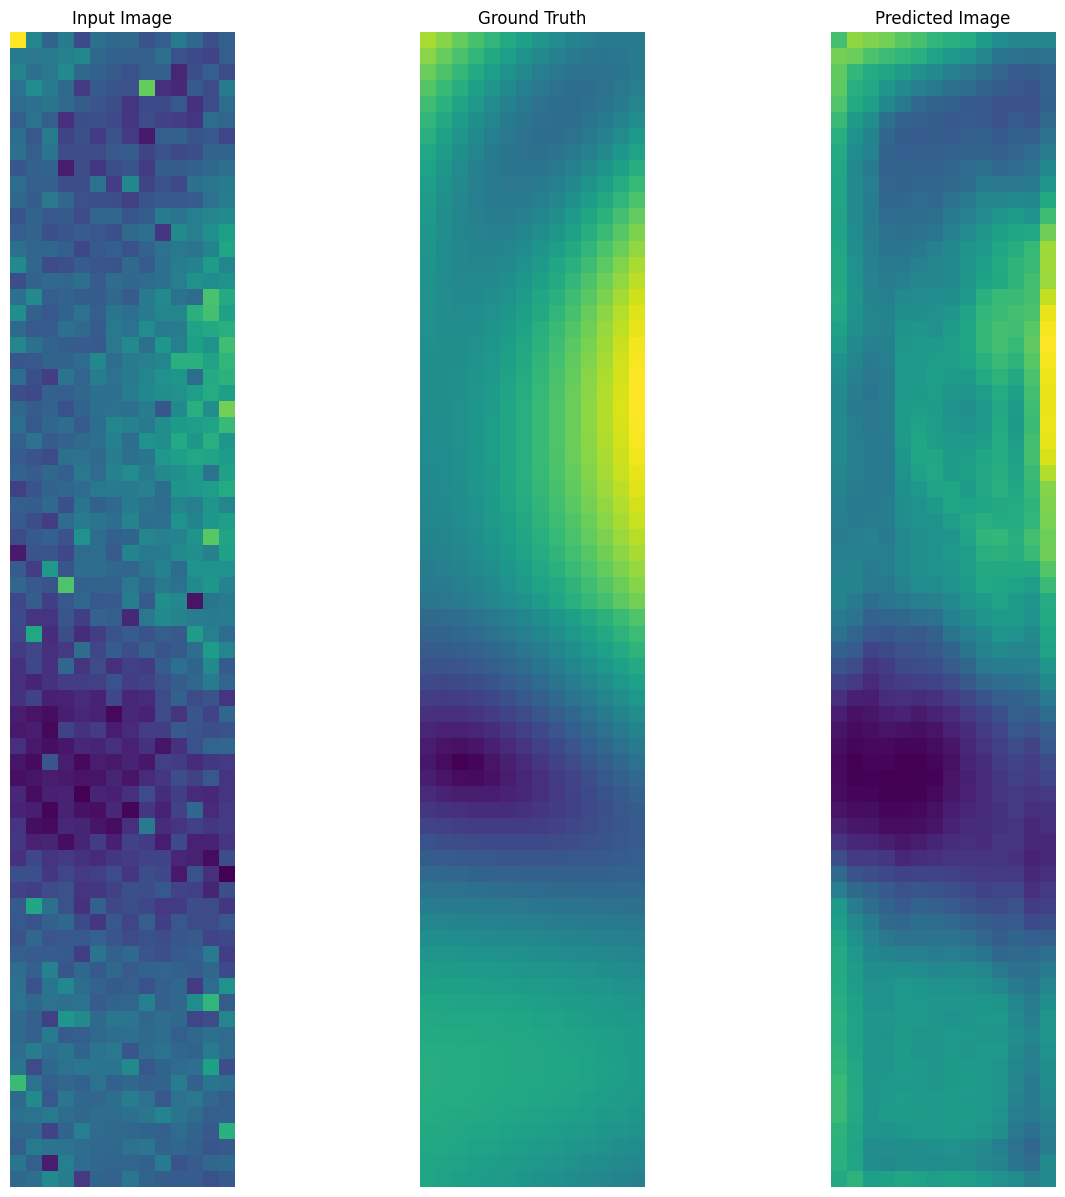

Step: 350


In [33]:
fit(trainset, testset, steps=350, batch=32)

In [34]:
generator.save('Sig2Sig.h5')